In [ ]:
# Projeto Marinha do Brasil

# Autor: Natanael Junior (natmourajr@gmail.com)
# Laboratorio de Processamento de Sinais - UFRJ


In [2]:
import os
import pickle
import numpy as np
import time

init_time = time.time()

from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.externals import joblib

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 18

%matplotlib inline

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

outputpath = os.environ['OUTPUTDATAPATH']
main_analysis_path = os.environ['SONAR_WORKSPACE']
analysis_path = outputpath+'/StationarityAnalysis'
pict_path = analysis_path+'/picts'


m_time = time.time()


subfolder = '4classes_old'
n_pts_fft = 1024
decimation_rate = 3

if(not os.path.exists(outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))):
    print outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.pickle'%(
        subfolder,n_pts_fft,decimation_rate)+' doesnt exist...please create it'
    exit()
    
#Read lofar data
[data,class_labels] = joblib.load(outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))
m_time = time.time()-m_time
print 'Time to read data file: '+str(m_time)+' seconds'


Time to import all libraries: 1.90227079391 seconds
Time to read data file: 8.48976302147 seconds


# Show Time Distributions
This plot represents the time distributions

Processing Class: ClassA
Processing Class: ClassB
Processing Class: ClassC
Processing Class: ClassD


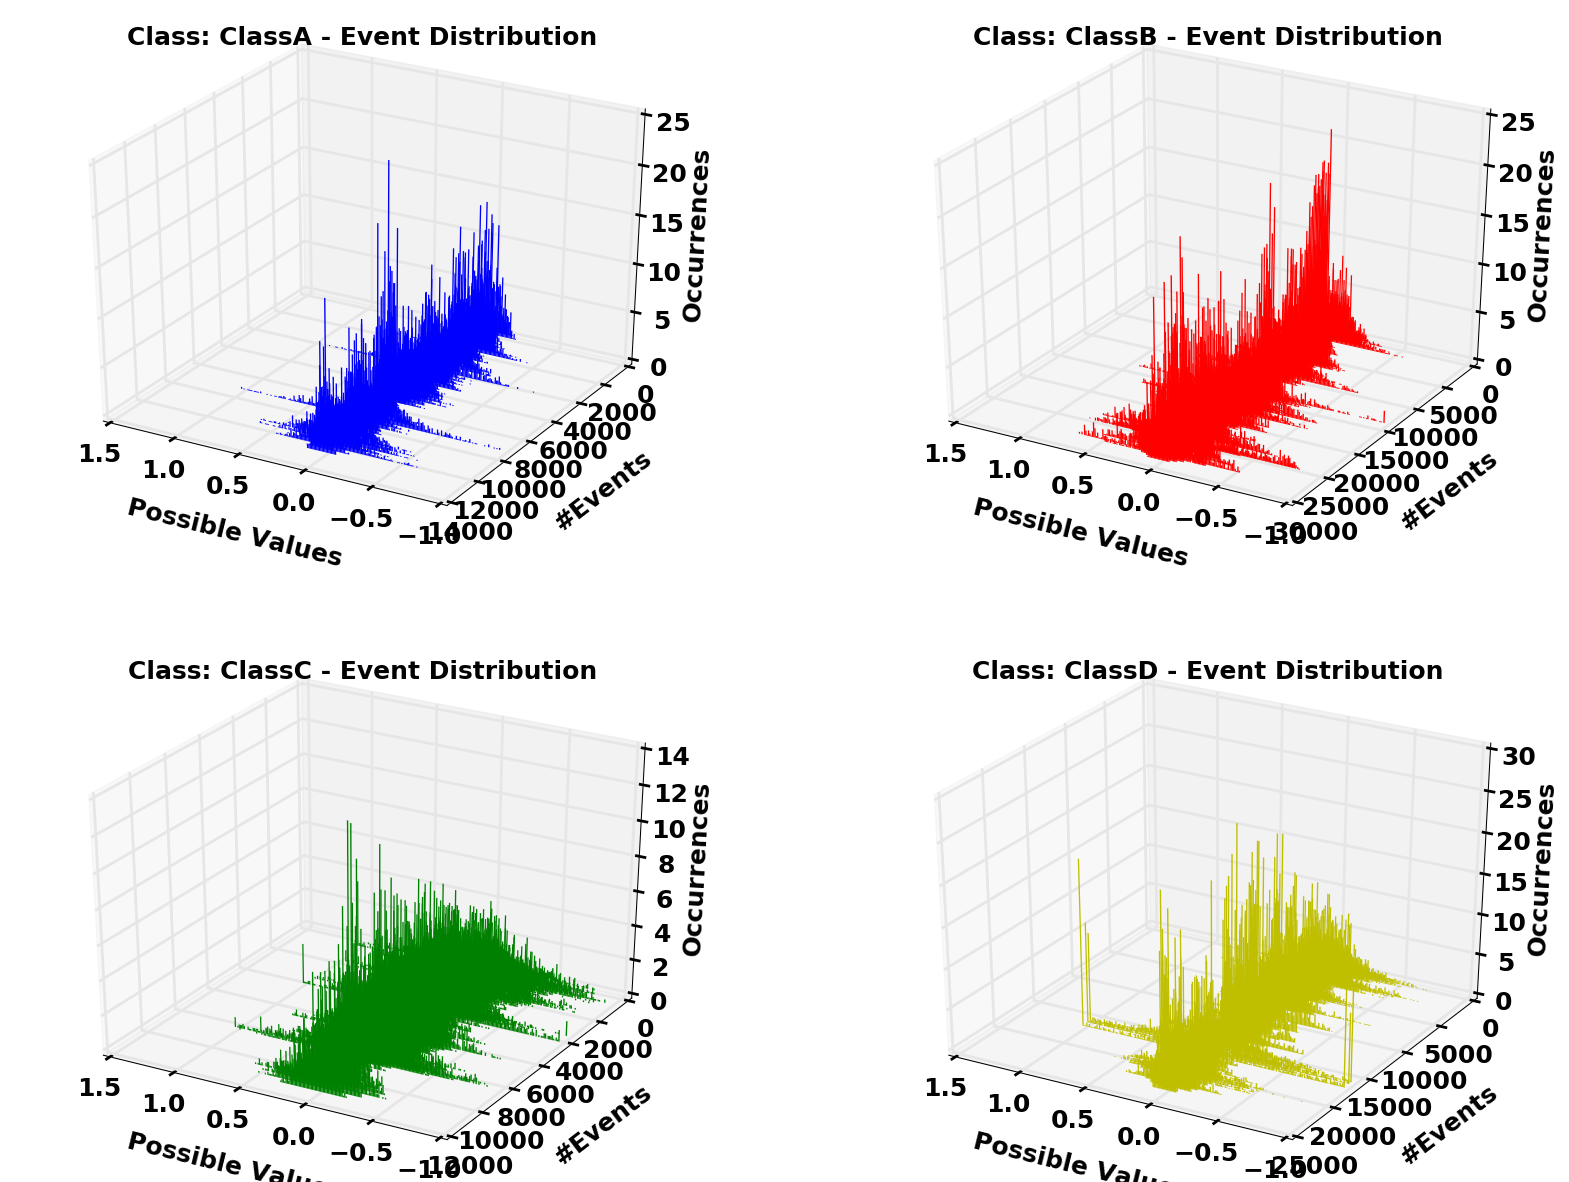

In [9]:
# Show Window Distributions
from mpl_toolkits.mplot3d import Axes3D
fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,15))

m_colors = ['b', 'r', 'g', 'y']

bins = np.linspace(-1,1,200)
ax = {}

for iclass, iclass_label in enumerate(class_labels):
    print 'Processing Class: %s' % (iclass_label)
    
    ax[iclass] = plt.subplot(2,2,iclass+1, projection='3d')
    #ax = plt.subplot(2,2,iclass+1)
    m_fontsize = 18
    plt.title('Class: %s - Event Distribution'%(iclass_label), fontsize= m_fontsize, fontweight="bold")
    ax[iclass].set_xlabel('Possible Values', fontsize= m_fontsize, fontweight="bold")
    ax[iclass].set_ylabel('#Events', fontsize= m_fontsize, fontweight="bold")
    ax[iclass].set_zlabel('Occurrences', fontsize= m_fontsize, fontweight="bold")
    
    ax[iclass].xaxis.labelpad = 20
    ax[iclass].yaxis.labelpad = 20
    
    # access run information
    sum_events = 0
    for irun in range(len(data[iclass])):
        qtd_runs = len(data[iclass])
        # access data from the window data vector
        #print 'Processing irun: ', irun, ' - Number of Events: ', data[iclass][irun]['Windows'].shape[0]
        qtd_events = data[iclass][irun]['Windows'].shape[0]
        for ievent in range(0,qtd_events,qtd_events/10):
            #print 'ievent: ', ievent
            event = data[iclass][irun]['Windows'][ievent,:]
            
            m_height,bins_centers = np.histogram(event,bins=bins, 
                                                 normed=True, density=True)
            m_height = np.append(m_height,0.0)
            
            ax[iclass].bar(bins_centers,m_height,zs=sum_events+ievent
                           ,zdir='y',width=0.01,color=m_colors[iclass], linewidth=0)
            # for events
            #break
        # for runs
        sum_events = sum_events+qtd_events
        #break
    # for classes
    #break
    
if False:
    # Saving processing rotating 
    for angle in range(0,181,10):
        for iclass, iclass_label in enumerate(class_labels):
            #print 'Rotating Class: ',iclass_label
            ax[iclass].view_init(30,angle)
        pict_name = pict_path+'/'+'KLDivInTime_%s_%i_fft_pts_%i_decimation_rate_TimeDists_%i_angle'%(
            subfolder,n_pts_fft,decimation_rate, angle)
        print 'Creating pict for angle: ', angle, ' picture'
        plt.savefig(pict_name+'.png')
        plt.savefig(pict_name+'.pdf')


for iclass, iclass_label in enumerate(class_labels):
    ax[iclass].view_init(30,120)
    
pict_name = pict_path+'/'+'KLDivInTime_%s_%i_fft_pts_%i_decimation_rate_TimeDists.pdf'%(
            subfolder,n_pts_fft,decimation_rate)
plt.savefig(pict_name)

In [23]:
#Measure KL Divergence

Processing Class: ClassA
Processing Class: ClassB
Processing Class: ClassC
Processing Class: ClassD
Showing Class: ClassA
Showing Class: ClassB
Showing Class: ClassC
Showing Class: ClassD


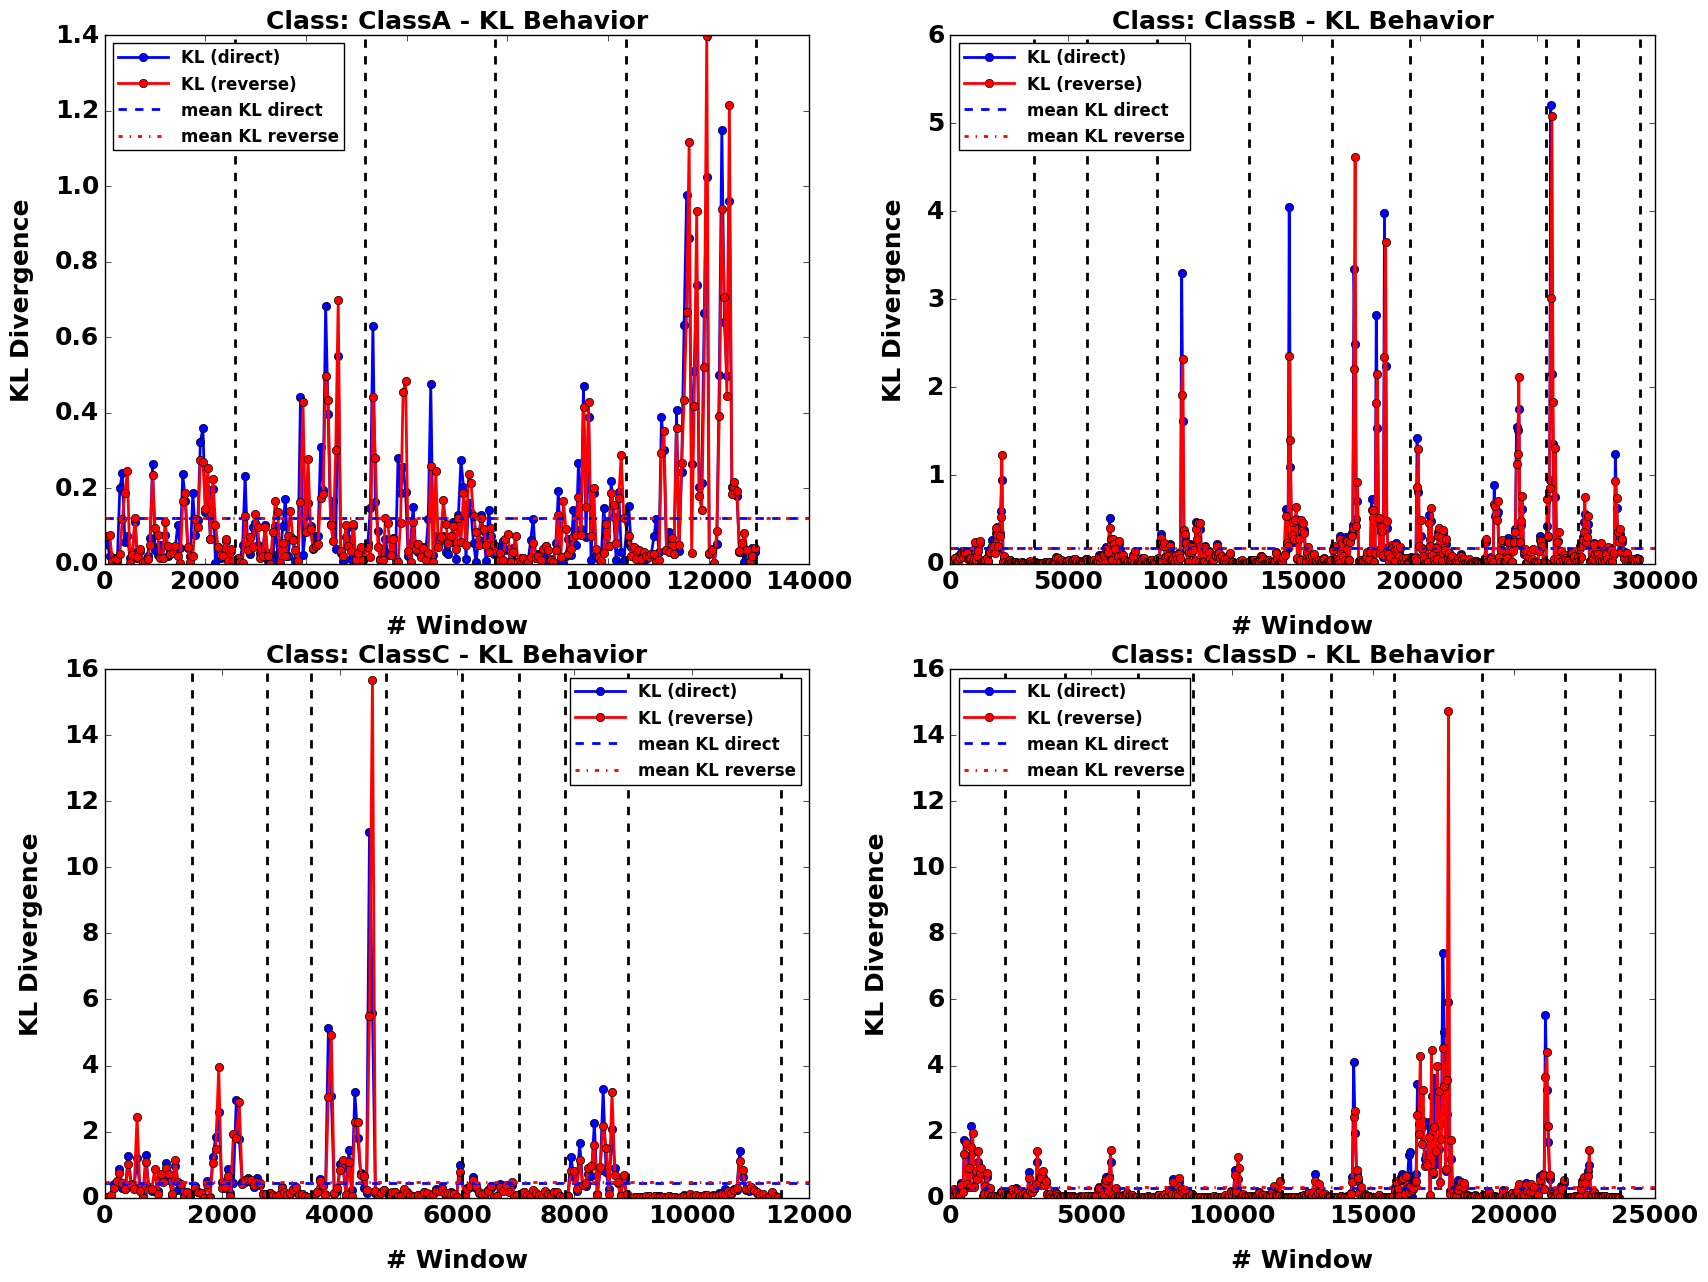

In [6]:
# Show KL Divergence between two consecutive windows

from Functions import StatFunctions as stats

from sklearn.neighbors import KernelDensity
from mpl_toolkits.mplot3d import Axes3D
fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,15))


m_colors = ['b', 'r', 'g', 'y']

bins = np.linspace(-1,1,200)
ax = {}

kdes = {}
pdfs = {}

windows_per_run = {}
sum_windows_per_run = {}
kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'

analysis_step = 50


for iclass, iclass_label in enumerate(class_labels):
    print 'Processing Class: %s' % (iclass_label)
    
    kdes[iclass] = {}
    pdfs[iclass] = {}
    windows_per_run[iclass] = {}
    sum_windows_per_run[iclass] = {}

    for irun in range(len(data[iclass])):
        qtd_runs = len(data[iclass])
        
        #print 'Processing run: %i of %i' %(irun, qtd_runs)
        
        kdes[iclass][irun] = {}
        pdfs[iclass][irun] = {}
        windows_per_run[iclass][irun] = 0
        sum_windows_per_run[iclass][irun] = 0
        
        qtd_windows = data[iclass][irun]['Windows'].shape[0]
        
        for ievent in range(0,qtd_windows,analysis_step):
            #print 'ievent: ', ievent, ' - total_windows: ', qtd_events
            event = data[iclass][irun]['Windows'][ievent,:]
            event = event[:, np.newaxis]
            kdes[iclass][irun][ievent] = KernelDensity(kernel=kernel, bandwidth=0.5).fit(event)
            pdfs[iclass][irun][ievent] = np.exp(kdes[iclass][irun][ievent].score_samples(
                    bins[:, np.newaxis]))
        windows_per_run[iclass][irun] = qtd_windows
        if irun == 0:
            sum_windows_per_run[iclass][irun] = qtd_windows
        else:
            sum_windows_per_run[iclass][irun] = sum_windows_per_run[iclass][irun-1]+qtd_windows

kl_forward = {}
kl_reverse = {}
iwindow = {}

for iclass, iclass_label in enumerate(class_labels):
    print 'Showing Class: %s' % (iclass_label)
    ax[iclass] = plt.subplot(2,2,iclass+1)

    m_fontsize = 18
    plt.title('Class: %s - KL Behavior'%(iclass_label), fontsize= m_fontsize, fontweight="bold")
    ax[iclass].set_xlabel('# Window', fontsize= m_fontsize, fontweight="bold")
    ax[iclass].set_ylabel('KL Divergence', fontsize= m_fontsize, fontweight="bold")
    
    ax[iclass].xaxis.labelpad = 15
    ax[iclass].yaxis.labelpad = 15
   
    kl_forward[iclass] = []
    kl_reverse[iclass] = []
    
    old_pdf = []
    act_pdf = []
    
    iwindow[iclass] = []
    
    for irun in range(len(data[iclass])):
        qtd_windows = data[iclass][irun]['Windows'].shape[0]
        for ievent in range(0,qtd_windows,analysis_step):
            if ievent == 0:
                continue
            old_pdf = pdfs[iclass][irun][ievent-analysis_step]
            act_pdf = pdfs[iclass][irun][ievent]
            
            [kl_forw,trash] = stats.KLDiv(old_pdf,act_pdf)
            [kl_rever,trash] = stats.KLDiv(act_pdf,old_pdf)
            kl_forward[iclass].append(np.absolute(kl_forw))
            kl_reverse[iclass].append(np.absolute(kl_rever))
            
            if irun == 0:
                iwindow[iclass].append(ievent)
            else:
                qtd_window_in_previous_runs = 0
                for jrun in range(0,irun):
                    qtd_window_in_previous_runs = (qtd_window_in_previous_runs+
                                                   data[iclass][jrun]['Windows'].shape[0])
                iwindow[iclass].append(qtd_window_in_previous_runs+ievent)
   
    plt.plot(iwindow[iclass],kl_forward[iclass],color='b',marker='o',label='KL (direct)')
    plt.plot(iwindow[iclass],kl_reverse[iclass],color='r',marker='o',label='KL (reverse)')
    
    x_lim = ax[iclass].get_xlim()
    plt.plot(x_lim, np.mean(kl_forward[iclass])*np.ones_like(x_lim),color='b',linestyle='--',label='mean KL direct')
    plt.plot(x_lim, np.mean(kl_reverse[iclass])*np.ones_like(x_lim),color='r',linestyle='-.',label='mean KL reverse')
    ax[iclass].set_xlim(x_lim)


    plt.legend(loc='best')    

    y_lim = ax[iclass].get_ylim()
    for irun in range(len(data[iclass])):
        plt.plot(sum_windows_per_run[iclass][irun]*np.ones_like(y_lim),y_lim,color='k',linestyle='--')

    ax[iclass].set_ylim(y_lim)
    
pict_name = pict_path+'/'+'KLDivInTime_%s_%i_fft_pts_%i_decimation_rate_KLDiv.pdf'%(
            subfolder,n_pts_fft,decimation_rate)
plt.savefig(pict_name)



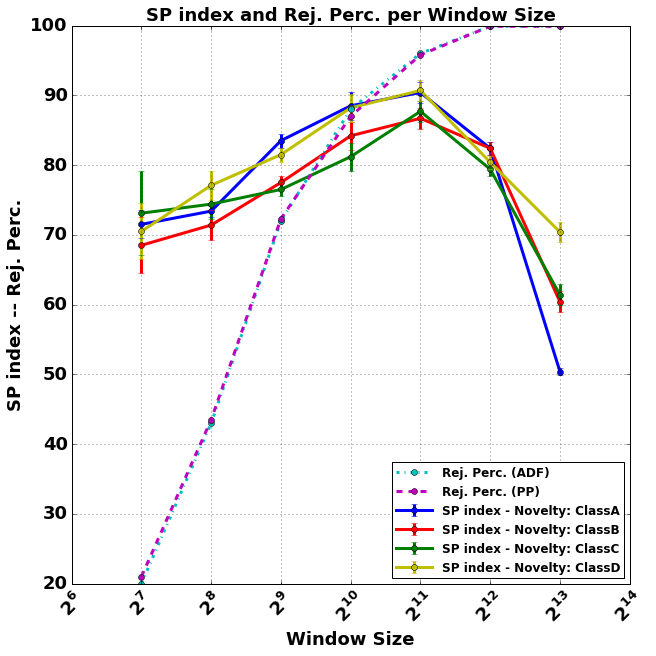

In [6]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 18

%matplotlib inline

fig = plt.figure(figsize=(10,10))

adf_pts = [20.0, 43.0, 72.0, 88.0, 96.0, 99.9, 99.9]
pp_pts = [21.0, 43.5, 72.3, 87.0, 95.8, 99.9, 99.9]

window_size = [128, 256, 512, 1024, 2048, 4096, 8192]


line_width = 3.0
m_leg = []

sp_mean_pts = [71.5, 73.4, 83.5, 88.5, 90.4, 82.4, 50.4]
sp_var_pts =  [02.0, 00.8, 01.0, 02.0, 01.5, 00.9, 00.5]

plt.errorbar(window_size, sp_mean_pts, sp_var_pts, 
             marker='o', color='b', linewidth=line_width, label='SP index - Novelty: ClassA')
#m_leg.append('SP index (NN)')

sp_mean_pts = [68.5, 71.4, 77.5, 84.2, 86.7, 82.4, 60.4]
sp_var_pts =  [04.0, 02.1, 01.0, 02.0, 01.5, 00.9, 01.5]

plt.errorbar(window_size, sp_mean_pts, sp_var_pts, 
             marker='o', color='r', linewidth=line_width, label='SP index - Novelty: ClassB')

sp_mean_pts = [73.1, 74.4, 76.5, 81.2, 87.7, 79.4, 61.4]
sp_var_pts =  [06.0, 02.1, 01.0, 02.0, 01.5, 01.0, 01.5]

plt.errorbar(window_size, sp_mean_pts, sp_var_pts, 
             marker='o', color='g', linewidth=line_width, label='SP index - Novelty: ClassC')

sp_mean_pts = [70.5, 77.1, 81.5, 88.2, 90.7, 80.4, 70.4]
sp_var_pts =  [04.0, 02.1, 01.0, 02.0, 01.5, 00.9, 01.5]

plt.errorbar(window_size, sp_mean_pts, sp_var_pts, 
             marker='o', color='y', linewidth=line_width, label='SP index - Novelty: ClassD')

plt.semilogx(window_size, adf_pts, basex=2, 
             marker='o', color='c', linewidth=line_width, 
             ls='-.', label='Rej. Perc. (ADF)')
#m_leg.append('Rej. Perc. (ADF)')

plt.semilogx(window_size, pp_pts, basex=2, 
             marker='o', color='m', linewidth=line_width,
            ls='--',label='Rej. Perc. (PP)')
#m_leg.append('Rej. Perc. (PP)')

plt.legend(loc='best')

plt.grid()

xticks = [64,128, 256, 512, 1024, 2048, 4096, 8192,8192*2]

plt.xticks(xticks,rotation=45)

plt.title('SP index and Rej. Perc. per Window Size',
          fontsize=18, fontweight='bold')
plt.xlabel('Window Size',fontsize=18, fontweight='bold')
plt.ylabel('SP index -- Rej. Perc.',fontsize=18, fontweight='bold')


pict_name = pict_path+'/'+'KLDivInTime_%s_%i_fft_pts_%i_decimation_rate_NN_eff.pdf'%(
            subfolder,n_pts_fft,decimation_rate)


plt.savefig(pict_name)